# Marina Lebedina
## ID: 12249127

# HW 5. Exponentially Weighted Regression

Exponentially Weighted Regression follows the idea that observations in the distant past are down-weighted in the likelihood function relative to more recent observations. This approach gives much better results in comparison to simple regression especially when underlying data generating process is believed to be **non-stationary over time**. By taking into consideration this non-stationarity, we employ some kind of data truncation, ignoring data which is ‘old enough’ under the assumption that market conditions make data prior to that point irrelevant to the predictive accuracy of our model.

We will consider several values to specify exponential decay, i.e. we will consider different values of lambdas and convert them into alphas which we will use as a parameter in exponentially-weighted regression. 

$$\lambda = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] $$ 

which correpond to $10, 20, 30, 40, 50, 60$ days which regression "takes into consideration" assigning less "importance weight" to observations further away from the current moment. In the pool of stocks under consideration there will be stocks corresponding to companies from different sectors, and thus we need to consider different "smoothing" parameters as for some industries past doesn't play a huge role, while for other it's extrmely important. For example, for tech companies we would expect past information from long time ago to play much less role in prediciton of future returns in comparison to companies operating in natural resources or energy sectors. That is why we will consider such a wide range of lamda values.

We will use the following formula to convert lambda into alpha:

$$ \alpha = 1 - \exp^{-\lambda} $$

and will serve as an input parameter for exponentially-weighted regression.

Exponential-Weighted as well as Windowed regressions will be implemented and compared on the basis of out-of-sample performance for $t+20$ dates, where t = [2018-06-29, 2018-12-31, 2019-06-28, 2019-11-29]. 

# 1. Obtain daily data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from tqdm import tnrange
from pandas.tseries.offsets import BDay
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')
quandl.ApiConfig.api_key = 'bWbMQmPczynWg63DzkA9'

Let us take a pool of 250 tickers from the previous home work.

In [2]:
prev_hw = pd.read_csv('hw4_data.csv')
tckr_unique = prev_hw['Ticker'].unique()

rand300 = prev_hw['Ticker'].unique()[:250]
rand300 = list(rand300)
rand300.append('PGF')
rand300.append('JOF')
rand300.append('IBM')
rand300.append('AAPL')
rand300.append('SPY')

data = pd.DataFrame(columns = ['Date','Ticker','Adj_Close','Daily_ret'])

for i in tnrange(len(rand300)):
    ticker = rand300[i]
    data_p = quandl.get('EOD/{}'.format(ticker), start_date='2016-01-04', end_date='2020-01-31')
    p_df = data_p[['Adj_Close']]
    p_df['Ticker'] = ticker
    p_df['Daily_ret'] = p_df['Adj_Close'].pct_change()
    p_df = p_df.reset_index()
    data = data.append(p_df)
    
data = data.set_index('Date')

In [3]:
def calc_betas(ticker, data, alpha, thres_date):
    
    pair = pd.DataFrame(index=data.index, columns=['r_{}'.format(ticker), 'r_SPY'])
    pair['r_{}'.format(ticker)] = data[data['Ticker'] == ticker]['Daily_ret']
    pair['r_SPY'] = data[data['Ticker'] == 'SPY']['Daily_ret']
    pair = pair[(pair.index <= thres_date)]
    pair = pair.dropna()

    pair_cov = pair.ewm(alpha=alpha).cov()
    spy_var = pair[['r_SPY']].ewm(alpha=alpha).var()
    
    cov = pair_cov[~pair_cov.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    var = spy_var[~spy_var.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    betas = cov/var
    
    beta = betas[-1]
        
    return beta

In [4]:
thres_dates = ['2018-06-29', '2018-12-31', '2019-06-28', '2019-11-29']
lambdas = [0.1, 0.2, 0.3, 0.4, 0.6]

In [5]:
indices = []

for i in range(len(thres_dates)):
    date = thres_dates[i]
    for j in range(len(lambdas)):
        lam = lambdas[j]
        idx = str(date) + '_' + str(lam)
        indices.append(idx)
        
beta_stat = pd.DataFrame(index=indices, columns=rand300)


for t in tnrange(len(rand300)):
    ticker = rand300[t]
    for i in range(len(thres_dates)):
        date = thres_dates[i]
        for j in range(len(lambdas)):
            lam = lambdas[j]
            alpha = 1 - np.exp(-lam)
            idx = str(date) + '_' + str(lam)
            beta = calc_betas(ticker, data, alpha, date)
            beta_stat.loc[idx,ticker] = beta
            
beta_stat = beta_stat.drop('SPY',axis=1)

In [6]:
beta_stat.head(3)

,AAN,NXST,OAS,OBCI,OC,ODP,OESX,OGE,OI,OIS,...,UFS,UGI,UGP,UHS,UNH,UNT,PGF,JOF,IBM,AAPL
2018-06-29_0.1,1.29842,1.00091,1.58775,-1.17528,0.541524,1.33549,1.28104,-0.323265,0.483728,0.773607,...,0.111457,-0.313733,1.43396,0.215827,0.739745,0.767498,0.0802016,0.65863,1.30389,0.927635
2018-06-29_0.2,1.6981,0.726981,1.28545,-1.88205,0.51444,0.828626,1.45027,-0.369252,0.435725,0.4625,...,0.132057,-0.425703,2.26792,0.00954722,0.423575,0.382296,0.123394,0.611961,1.50614,0.944843
2018-06-29_0.3,1.95782,0.466858,0.723635,-2.12389,0.403852,0.52433,1.2534,-0.324246,0.537266,0.00907417,...,0.20566,-0.430983,2.86264,-0.0852344,0.255053,-0.0151406,0.155298,0.506645,1.61379,0.915424


In [7]:
def calc_wind_betas(ticker, data, w, thres_date):

    pair = pd.DataFrame(index=data.index, columns=['r_{}'.format(ticker), 'r_SPY'])
    pair['r_{}'.format(ticker)] = data[data['Ticker'] == ticker]['Daily_ret']
    pair['r_SPY'] = data[data['Ticker'] == 'SPY']['Daily_ret']
    pair = pair[(pair.index <= thres_date)]
    pair = pair.dropna()
    
    pair_cov = pair.rolling(w).cov()
    spy_var = pair[['r_SPY']].rolling(w).var()
    
    cov = pair_cov[~pair_cov.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    var = spy_var[~spy_var.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    
    betas = cov/var
    
    beta = betas[-1]
    
    df = data.reset_index()
    idx_start = df[(df['Ticker'] == ticker) & (df['Date'] == thres_date)].index[0]
    idx_end = idx_start + 20
    actual = df.loc[idx_end, 'Daily_ret']
    actual_date = df.loc[idx_end, 'Date']
    
    return beta, actual_date

In [8]:
beta_w_stat = pd.DataFrame(index=indices, columns=rand300)
dates = []

for t in tnrange(len(rand300)):
    ticker = rand300[t]
    for i in range(len(thres_dates)):
        date = thres_dates[i]
        for j in range(len(lambdas)):
            lam = lambdas[j]
            win = int(2/lam)
            idx = str(date) + '_' + str(lam)
            beta_w, actual_date = calc_wind_betas(ticker, data, win, date)
            beta_w_stat.loc[idx,ticker] = beta_w
        dates.append(actual_date)
        
beta_w_stat = beta_w_stat.drop('SPY',axis=1)

In [9]:
beta_w_stat.head(3)

,AAN,NXST,OAS,OBCI,OC,ODP,OESX,OGE,OI,OIS,...,UFS,UGI,UGP,UHS,UNH,UNT,PGF,JOF,IBM,AAPL
2018-06-29_0.1,1.23915,1.39626,1.1377,-1.38864,0.904063,1.89724,1.09831,-0.692574,0.198176,0.663941,...,0.239623,-0.694385,1.39218,0.289739,0.990769,0.578285,0.0905653,0.769368,1.29935,0.973193
2018-06-29_0.2,1.2844,1.11215,3.03381,-2.12109,0.656733,0.899051,1.98089,-0.481952,0.215154,1.51741,...,-0.0642374,-0.454845,1.21818,0.124168,0.49416,1.35239,0.0592842,0.884966,1.38427,1.08306
2018-06-29_0.3,1.54544,0.582965,2.25346,-1.88561,0.43077,0.999198,-0.103795,-0.39594,0.022656,1.52995,...,0.066487,-0.552099,1.73458,-0.0928039,0.501445,0.939838,0.0860656,0.756018,1.52694,0.980179


In [10]:
def calc_c(ticker, data, data_start, data_end, w):

    pair = pd.DataFrame(index=data.index, columns=['r_{}'.format(ticker), 'r_SPY'])
    pair['r_{}'.format(ticker)] = data[data['Ticker'] == ticker]['Daily_ret']
    pair['r_SPY'] = data[data['Ticker'] == 'SPY']['Daily_ret']
    pair = pair[(pair.index <= date_end) & (pair.index > date_start)]
    pair = pair.dropna()
    
    pair_cov = pair.rolling(w).cov()
    spy_var = pair[['r_SPY']].rolling(w).var()
    
    cov = pair_cov[~pair_cov.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    var = spy_var[~spy_var.index.get_level_values(0).duplicated(keep='first')]['r_SPY'].values
    
    betas = cov/var
    
    beta = betas[-1]
    
    return beta

In [12]:
c_stat = pd.DataFrame(index=np.unique(dates), columns=rand300)
win = 20

for d in tnrange(len(np.unique(dates))):
    date_end = np.unique(dates)[d]
    date_start = thres_dates[d]
    for t in range(len(rand300)):
        ticker = rand300[t]
        c = calc_c(ticker, data, date_start, date_end, win)
        c_stat.loc[date_end, ticker] = c
        
c_stat = c_stat.drop('SPY',axis=1)

In [13]:
c_stat.head(3)

,AAN,NXST,OAS,OBCI,OC,ODP,OESX,OGE,OI,OIS,...,UFS,UGI,UGP,UHS,UNH,UNT,PGF,JOF,IBM,AAPL
2018-07-30,0.793565,1.73961,1.27497,-0.0525434,-1.50137,1.93012,-1.11231,-0.359349,0.926568,0.12376,...,0.279286,-0.110057,1.5646,0.248865,0.730541,1.46565,0.104174,0.491286,0.494256,1.51723
2019-01-30,0.766305,0.665825,1.8022,1.25952,0.500721,1.42342,-0.720409,0.262516,1.13952,1.25887,...,0.682044,0.273267,0.585111,0.65689,0.709851,0.97647,0.134533,0.61564,0.858256,2.33317
2019-07-29,2.48449,1.98856,1.28029,0.620491,0.91252,2.71934,0.703554,0.619412,1.26118,3.27484,...,1.30839,0.0833394,1.10398,1.92779,0.399021,3.04253,0.0307645,0.527221,1.00103,1.53177


In [14]:
future_dates = c_stat.index.values

diff_dict_exp = {}
diff_dict_box = {}

for i in range(len(thres_dates)):
    fut_date = future_dates[i]
    if i != len(thres_dates)-1:
        date_start = thres_dates[i]
        date_end = thres_dates[i+1]
        mask_exp = beta_stat[(beta_stat.index >= date_start) & (beta_stat.index < date_end) ]
        mask_box = beta_w_stat[(beta_w_stat.index >= date_start) & (beta_w_stat.index < date_end) ]
    else:
        date_start = thres_dates[i]
        mask_exp = beta_stat[beta_stat.index >= date_start]
        mask_box = beta_w_stat[beta_w_stat.index >= date_start]
    
    diff_exp = np.abs(mask_exp - c_stat.loc[fut_date])
    diff_box = np.abs(mask_box - c_stat.loc[fut_date])
    
    diff_dict_exp[date_start] = diff_exp
    diff_dict_box[date_start] = diff_box

In [15]:
def plot_abs2(beta_stat, beta_w_stat, c_stat, diff_exp, diff_box, date0, date1):
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_axes([0,0,1,1])

    colors = ['red','green','blue','orange','brown']
    for j in range(len(diff_exp.index), 0, -1):
        idx = diff_exp.index[j-1]
        ax.bar(beta_stat.columns.values, diff_box.loc[idx] - diff_exp.loc[idx], color=colors[j-1], label=idx)
        plt.xticks([])

    plt.legend()
    plt.xlabel('Tickers')
    plt.ylabel('Regression Coefficient (actual/estimated)')
    plt.xticks([])
    plt.title('Relationship b/t estimated with Windowed and Exp.Weighted Regressions and actual out-of-sample Regression Coefficients')
    plt.show()
    
def plot_best(beta_stat, beta_w_stat, c_stat, diff_exp, diff_box, best_param, thres_date):
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_axes([0,0,1,1])

    ax.errorbar(beta_stat.columns.values, beta_stat.loc[best_param], \
                 diff_exp.loc[best_param], color='blue', label='beta', fmt='.g', linewidth=3,\
               markeredgewidth=6)

    ax.errorbar(beta_w_stat.columns.values, beta_w_stat.loc[best_param], \
                 diff_box.loc[best_param], color='green', label='b', fmt='.b', linewidth=3, \
                markeredgewidth=6)

    ax.scatter(c_stat.columns.values, c_stat.loc[thres_date], color='red', label='c', marker='s', s=66)
    plt.legend()
    plt.xlabel('Tickers')
    plt.ylabel('Regression Coefficient (actual/estimated)')
    plt.xticks([])
    plt.title('Relationship b/t estimated with Windowed and Exp.Weighted Regressions and actual out-of-sample Regression Coefficients')
    plt.show()

Parameter corresponding to MIN abs difference:
 EXP.WEI: 2018-06-29_0.1
 WINDOW: 2018-06-29_0.1
Parameter corresponding to MAX abs difference:
 EXP.WEI: 2018-06-29_0.6
 WINDOW: 2018-06-29_0.6


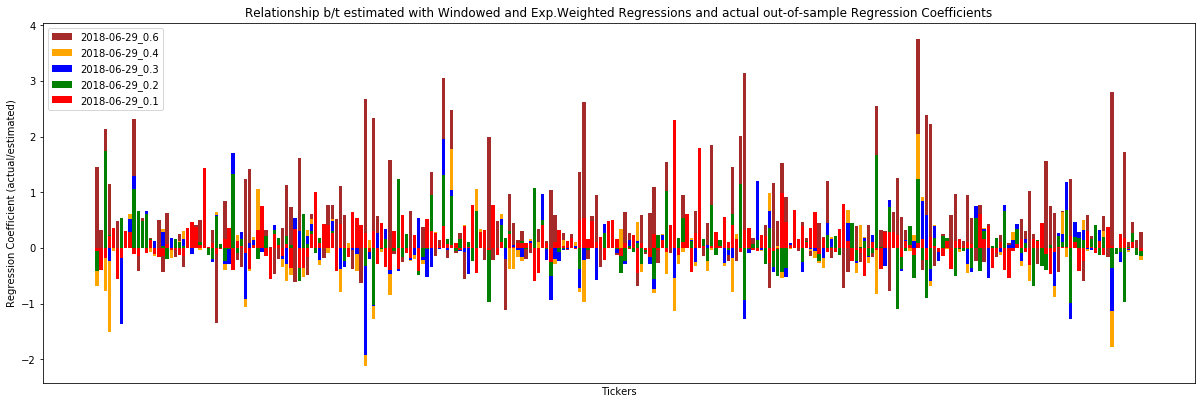

Parameter corresponding to MIN abs difference:
 EXP.WEI: 2018-12-31_0.1
 WINDOW: 2018-12-31_0.1
Parameter corresponding to MAX abs difference:
 EXP.WEI: 2018-12-31_0.6
 WINDOW: 2018-12-31_0.6


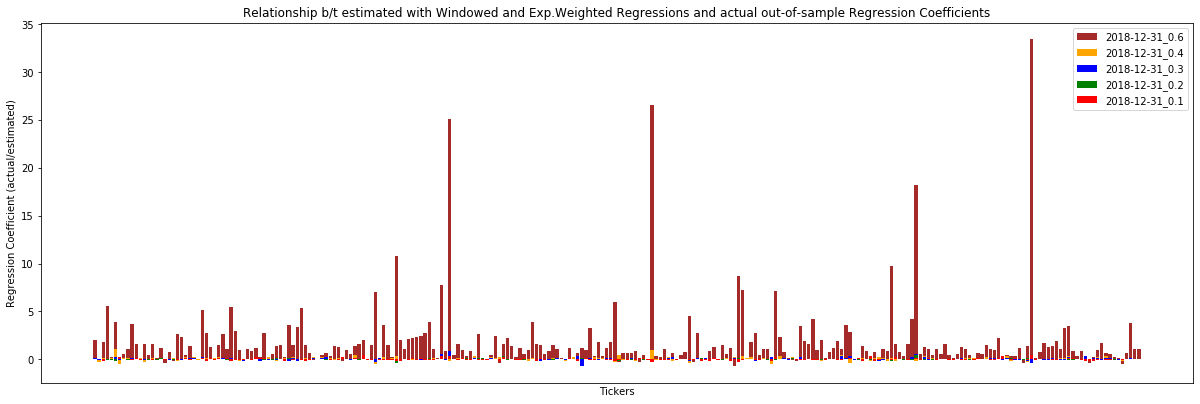

Parameter corresponding to MIN abs difference:
 EXP.WEI: 2019-06-28_0.1
 WINDOW: 2019-06-28_0.1
Parameter corresponding to MAX abs difference:
 EXP.WEI: 2019-06-28_0.6
 WINDOW: 2019-06-28_0.6


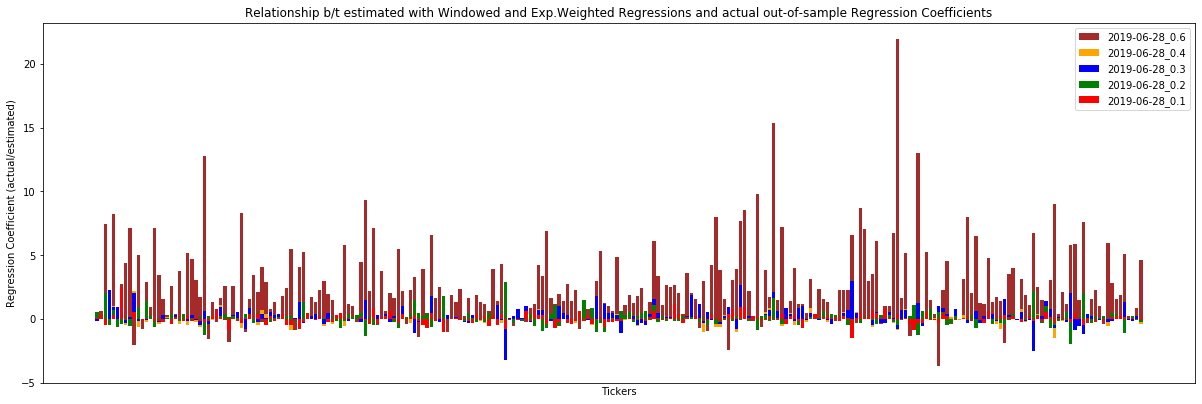

Parameter corresponding to MIN abs difference:
 EXP.WEI: 2019-11-29_0.2
 WINDOW: 2019-11-29_0.1
Parameter corresponding to MAX abs difference:
 EXP.WEI: 2019-11-29_0.6
 WINDOW: 2019-11-29_0.6


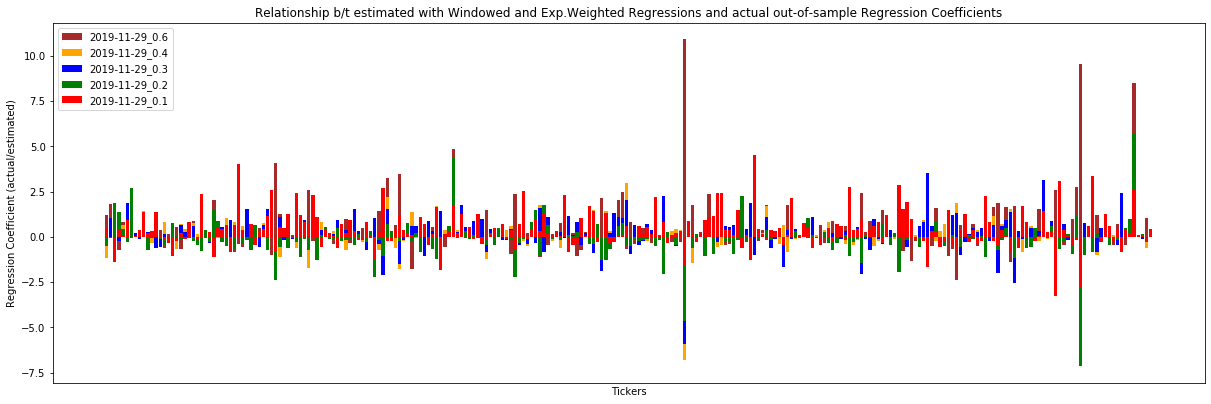

In [16]:
dates = np.unique(dates)

min_box = []
min_exp = []

for i in range(len(thres_dates)):
    date0 = thres_dates[i]
    date1 = dates[i]
    df_box = diff_dict_box[date0]
    df_exp = diff_dict_exp[date0]
    min_b = df_box.mean(axis=1).idxmin()
    min_e = df_exp.mean(axis=1).idxmin()
    max_b = df_box.mean(axis=1).idxmax()
    max_e = df_exp.mean(axis=1).idxmax()
    min_box.append(min_b)
    min_exp.append(min_e)
    print("Parameter corresponding to MIN abs difference:\n EXP.WEI: {}\n WINDOW: {}".format(min_b, min_e))
    print("Parameter corresponding to MAX abs difference:\n EXP.WEI: {}\n WINDOW: {}".format(max_b, max_e))
    plot_abs2(beta_stat, beta_w_stat, c_stat, df_exp, df_box, date0, date1)

2018-06-29_0.1


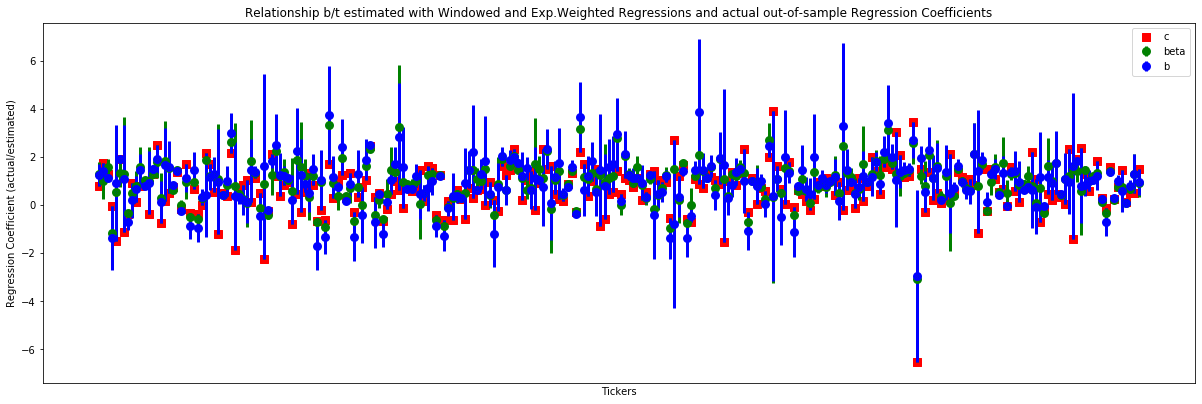

2018-12-31_0.1


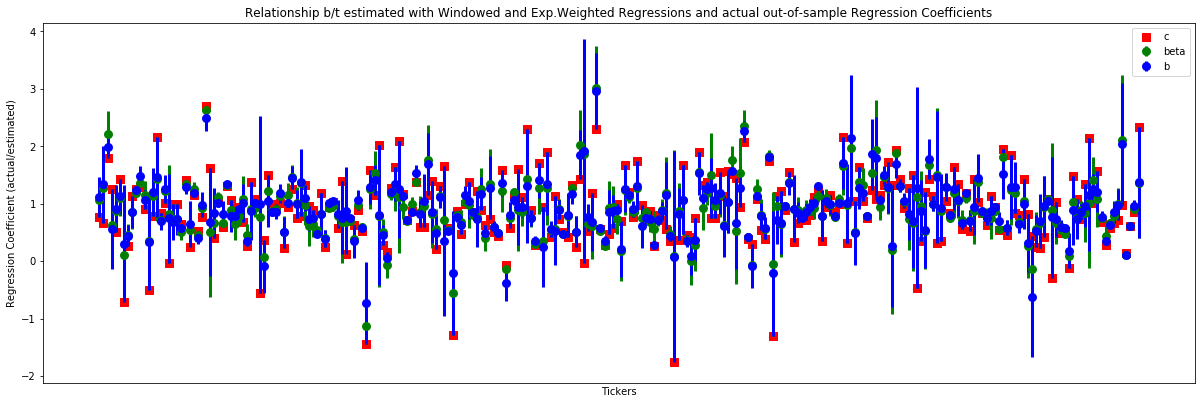

2019-06-28_0.1


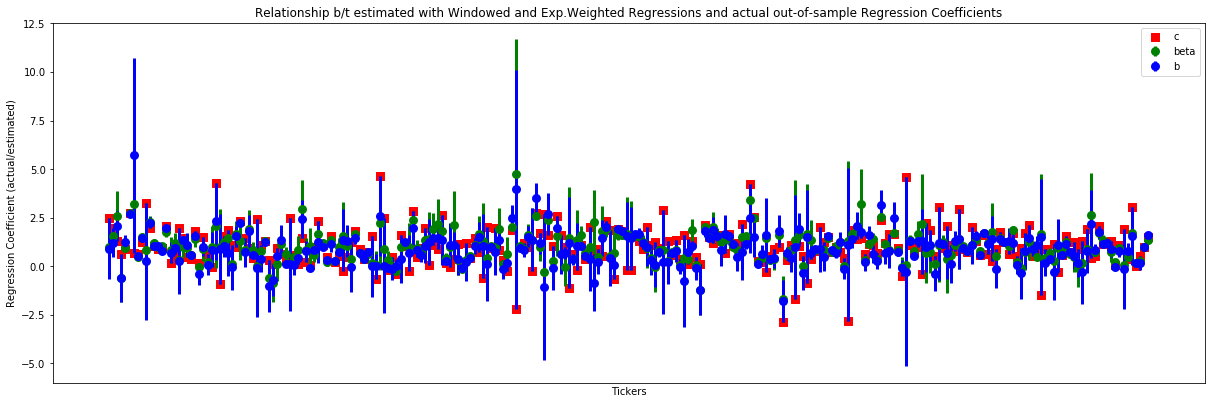

2019-11-29_0.2


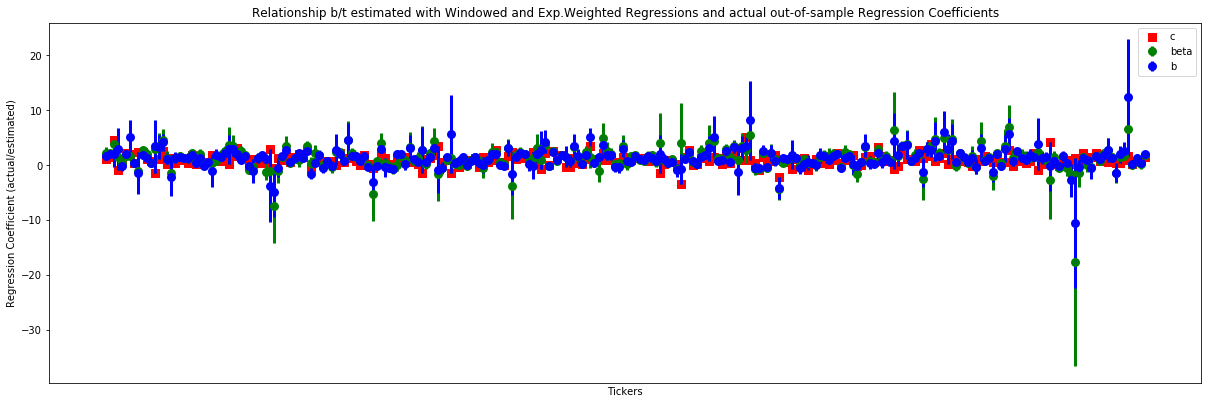

In [17]:
for i in range(len(thres_dates)):
    date0 = thres_dates[i]
    date1 = dates[i]
    df_box = diff_dict_box[date0]
    df_exp = diff_dict_exp[date0]
    best_param = min_box[i]
    print(best_param)
    plot_best(beta_stat, beta_w_stat, c_stat, df_exp, df_box, best_param, date1)

We measure the accuracy of out-of-sample prediction of Exponentially-Weighted Regression as the absolute difference between $\beta$ and $c$, i.e. 

$$e_s = |\beta_{t}^{i,\lambda} - c_s^i|$$

and for Windowed Regression we use the same approach:

$$e_s = |b_{t}^{i,w} -c_s^i|$$

where $w = \frac{1}{\lambda} $. 

The smaller the $e_s$ the better the model performs.

$c_s^i$ is an out-of-sample coefficient, corresponding to four different dates, i.e. to July 30 2018, Jan 30 2018, July 29 2019, Dec 29 2019 and calculated as $s=t^{'}+20$ where $t$ is June 29 2018, Dec 31 2018, June 28 2019, Nov 29 2019. $c_s^i$ is estimated using **Windowed Regression with parameter $w=20$** on out-of-sample data from $t^{'}$ to $s$.

As we can see from the plots above, for both Exponentially-Weighted and Windowed Regressions the **highest accuracy, i.e. the smallest absolute difference** between estimated coefficients is achieved when we use **$\lambda = 0.1$** for Exponentially-Weighted Regression and $w=20$ for Windowed Regression. 

We can also notice that **the closer the parameters to the "true" parameter of** $w=20$ **the higher the accuracy** of the model, i.e. the following is true for the **Exponential-Weighted Regression**:

$$ e_s(\lambda=0.6) > e_s(\lambda=0.5) > e_s(\lambda=0.4) > e_s(\lambda=0.3) \approx e_s(\lambda=0.1) > e(\lambda=0.2) $$

for **Windowed Regression**:

$$ e_s(w=60) > e_s(w=50) > e_s(w=40) > e_s(w=30) \approx e_s(w=10) > e(w=20) $$

Thus, we can conclude that the closer the parameter of the model "trained" on training set to the "true" one, the better the out-of-sample performance of this model.

From the plots and statistics above we can also see that **Exponentially-Weighted** Regression **gives on average higher accuracy**, i.e. smaller absolute difference, **in comparison to Windowed Regression** (we can see this from the fact that blue colot which corresponds to $b$ coefficients "dominates" on the plots, which means that erros are higher). Thus, we can conclude that taking into consideration past observations which occured far away and assigning a smaller "importance weight" to them we can indeed improve performance of the model in comparison to the model which does not differentiate between "importance of past".

Also, from the above analysis we can note that **the highest accuracy of prediction is achieved for out-of-sample dates Jan 30 2018 and Dec 29 2019**. This can be due to the **end of year effect**, where end of year for the company depends on its previous and recent performance and different reports, while in the middle of the year performance of the company is more influenced by uncertainty and different shocks.